# Who Directed That?

## A ML model to detect whether that's a Wes Anderson or a David Lynch movie

In [19]:
from fastbook import *
from fastai.vision import *
from fastai.vision.widgets import *
from decouple import config, AutoConfig

### Gather Data

In [20]:
config = AutoConfig(' ')
key = config('AZURE_SEARCH_KEY')

In [21]:
results = search_images_bing(key, 'wes anderson bottle rocket scene')
ims = results.attrgot('contentUrl')
len(ims)

145

In [23]:
dest = 'images/bottlerocket.jpg'
download_url(ims[0], dest)

Path('images/bottlerocket.jpg')

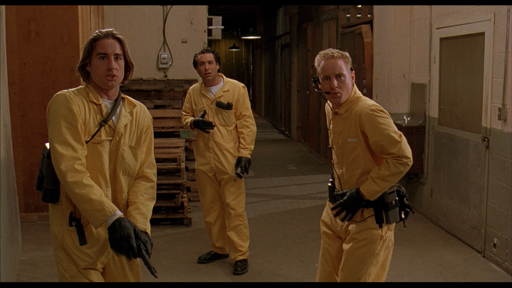

In [26]:
im = Image.open(dest)
im.to_thumb(512,512)

In [31]:
wa_movies_train = ['bottle rocket','rushmore','the royal tenebaums', 'the life aquatic with steve zissou',
            'the darjeeling limited','the grand budapest hotel','asteroid city']
wa_movies_val = ['the french dispatch','moonrise kingdom',]

dl_movies_train = ['eraserhead','the elephant man','wild at heart',
            'twin peaks','lost highway','inland empire']
dl_movies_val = ['mulholland drive','blue velvet',]

path = Path('movies')

In [45]:
if not path.exists():
    path.mkdir()
train_path = (path/'training')
if not train_path.exists():
    train_path.mkdir()
    for o in wa_movies_train:
        dest = (train_path/'wesanderson')
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'wes anderson {o} scene', max_images=30)
        download_images(dest, urls=results.attrgot('contentUrl'))

In [46]:
for o in dl_movies_train:
    dest = (train_path/'davidlynch')
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'david lynch {o} scene', max_images=30)
    download_images(dest, urls=results.attrgot('contentUrl'))

In [41]:
val_path = (path/'validation')
if not val_path.exists():
    val_path.mkdir()
    for o in wa_movies_val:
        dest = (val_path/'wesanderson')
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'wes anderson {o} scene', max_images=30)
        download_images(dest, urls=results.attrgot('contentUrl'))

In [42]:
for o in dl_movies_val:
    dest = (val_path/'davidlynch')
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'david lynch {o} scene', max_images=30)
    download_images(dest, urls=results.attrgot('contentUrl'))

In [48]:
fns = get_image_files(path)
fns

(#496) [Path('movies/training/davidlynch/f921cd00-d30c-4f7d-aef7-113690751300.png'),Path('movies/training/davidlynch/8a260340-4743-48bf-9c17-b79ff510fb33.jpg'),Path('movies/training/davidlynch/c0e96632-e024-45a1-a962-e24bdd6a3309.jpg'),Path('movies/training/davidlynch/b9d4df96-874b-4ea8-bbfd-17117687f1f4.png'),Path('movies/training/davidlynch/866b49e4-5f9b-4210-968f-b844fea2fa82.jpg'),Path('movies/training/davidlynch/bab863b6-6af3-4237-83d1-c6a3261d3a59.jpg'),Path('movies/training/davidlynch/3186b311-112f-4e01-8eaa-f1d7c56bd6c4.jpg'),Path('movies/training/davidlynch/75fc8e5d-cbbc-41a4-85fb-4efb99d3d4ed.jpg'),Path('movies/training/davidlynch/a0498206-ca77-4016-a80f-78bcab06819f.png'),Path('movies/training/davidlynch/e63f7b05-0fbd-4296-90e5-b97a7c953a4e.jpeg')...]

In [49]:
failed = verify_images(fns)
failed

(#25) [Path('movies/training/davidlynch/0c7c65c3-5815-49c2-afbd-377c581d0faa.jpg'),Path('movies/training/davidlynch/62dce7bc-9f0e-4028-8fab-89c409e0795a.jpg'),Path('movies/training/davidlynch/eb6e3f70-1533-40ba-954a-09b5d3447380.jpg'),Path('movies/training/davidlynch/94fec574-28da-476e-84f4-dc42357478ba.jpg'),Path('movies/training/davidlynch/ceac1e3e-c6a5-415d-8f07-60cea856a10b.png'),Path('movies/training/davidlynch/d4764947-8917-4891-8a55-e93769a2b857.jpg'),Path('movies/training/wesanderson/a13f7bc0-46b5-4d30-80e8-358d6d5fa3f5.jpg'),Path('movies/training/wesanderson/da038b25-9618-4333-a383-54f6fd83b5d0.png'),Path('movies/training/wesanderson/8c7d6d80-bd4e-40ba-972e-fc3a67d4ade3.jpg'),Path('movies/training/wesanderson/9b54ba25-09b2-4e27-aae7-c58e5179019d.jpg')...]

In [50]:
failed.map(Path.unlink);

### Preparing Dataloaders

In [182]:
scenes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(train_name='training', valid_name='validation'),
    get_y=parent_label,
    item_tfms=Resize(256))

In [253]:
dl_train = scenes.dataloaders(path, shuffle=True, val_shuffle=True)

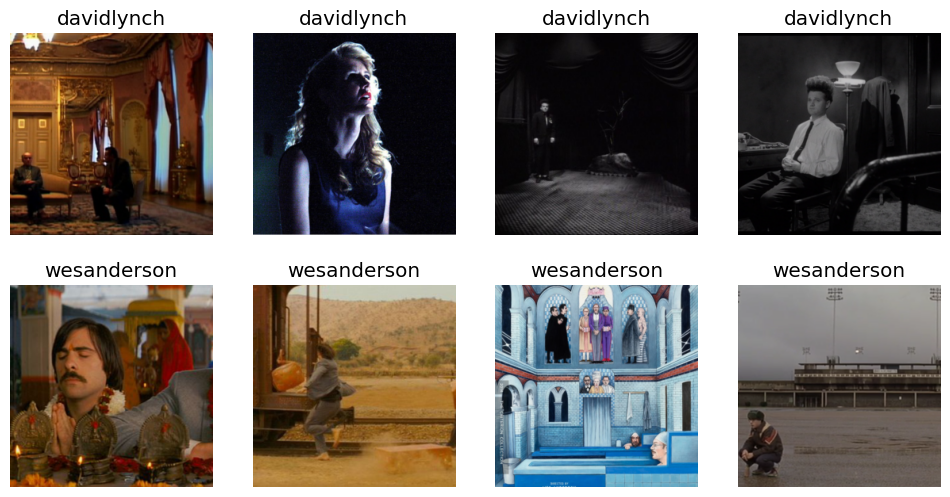

In [256]:
dl_train.train.show_batch(max_n=8, nrows=2)

In [184]:
learn = vision_learner(dl_train, resnet18, metrics=accuracy)
learn.fine_tune(6)

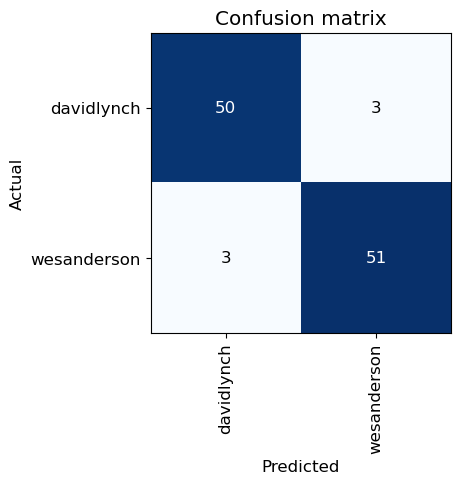

In [186]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Let's remove any shots of filming and duplicates

In [188]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [194]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

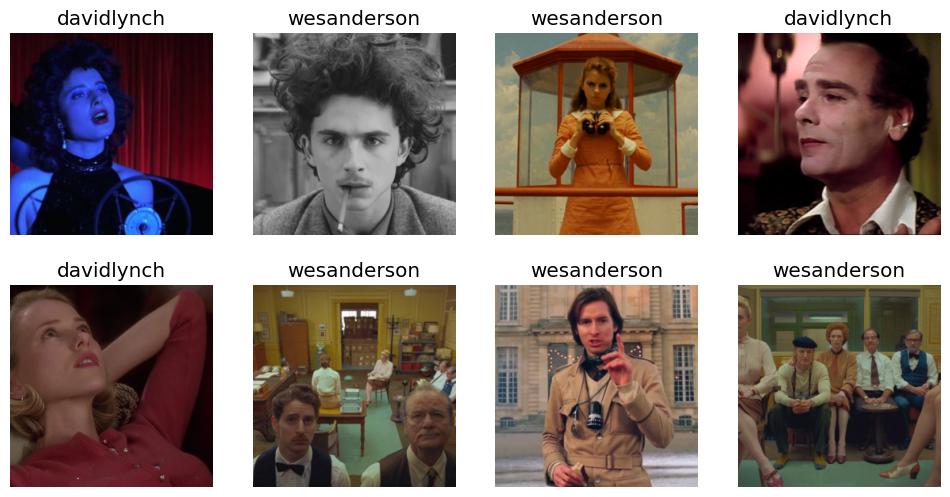

In [200]:
dl_train = scenes.dataloaders(path, shuffle=True, val_shuffle=True)
dl_train.valid.show_batch(max_n=8, nrows=2)

In [ ]:
learn = vision_learner(dl_train, resnet34, metrics=accuracy)
learn.fine_tune(8)

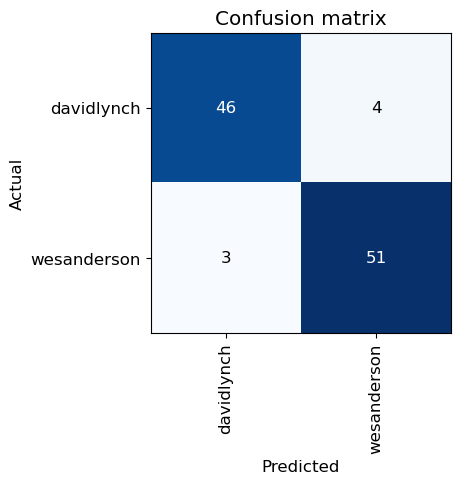

In [210]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

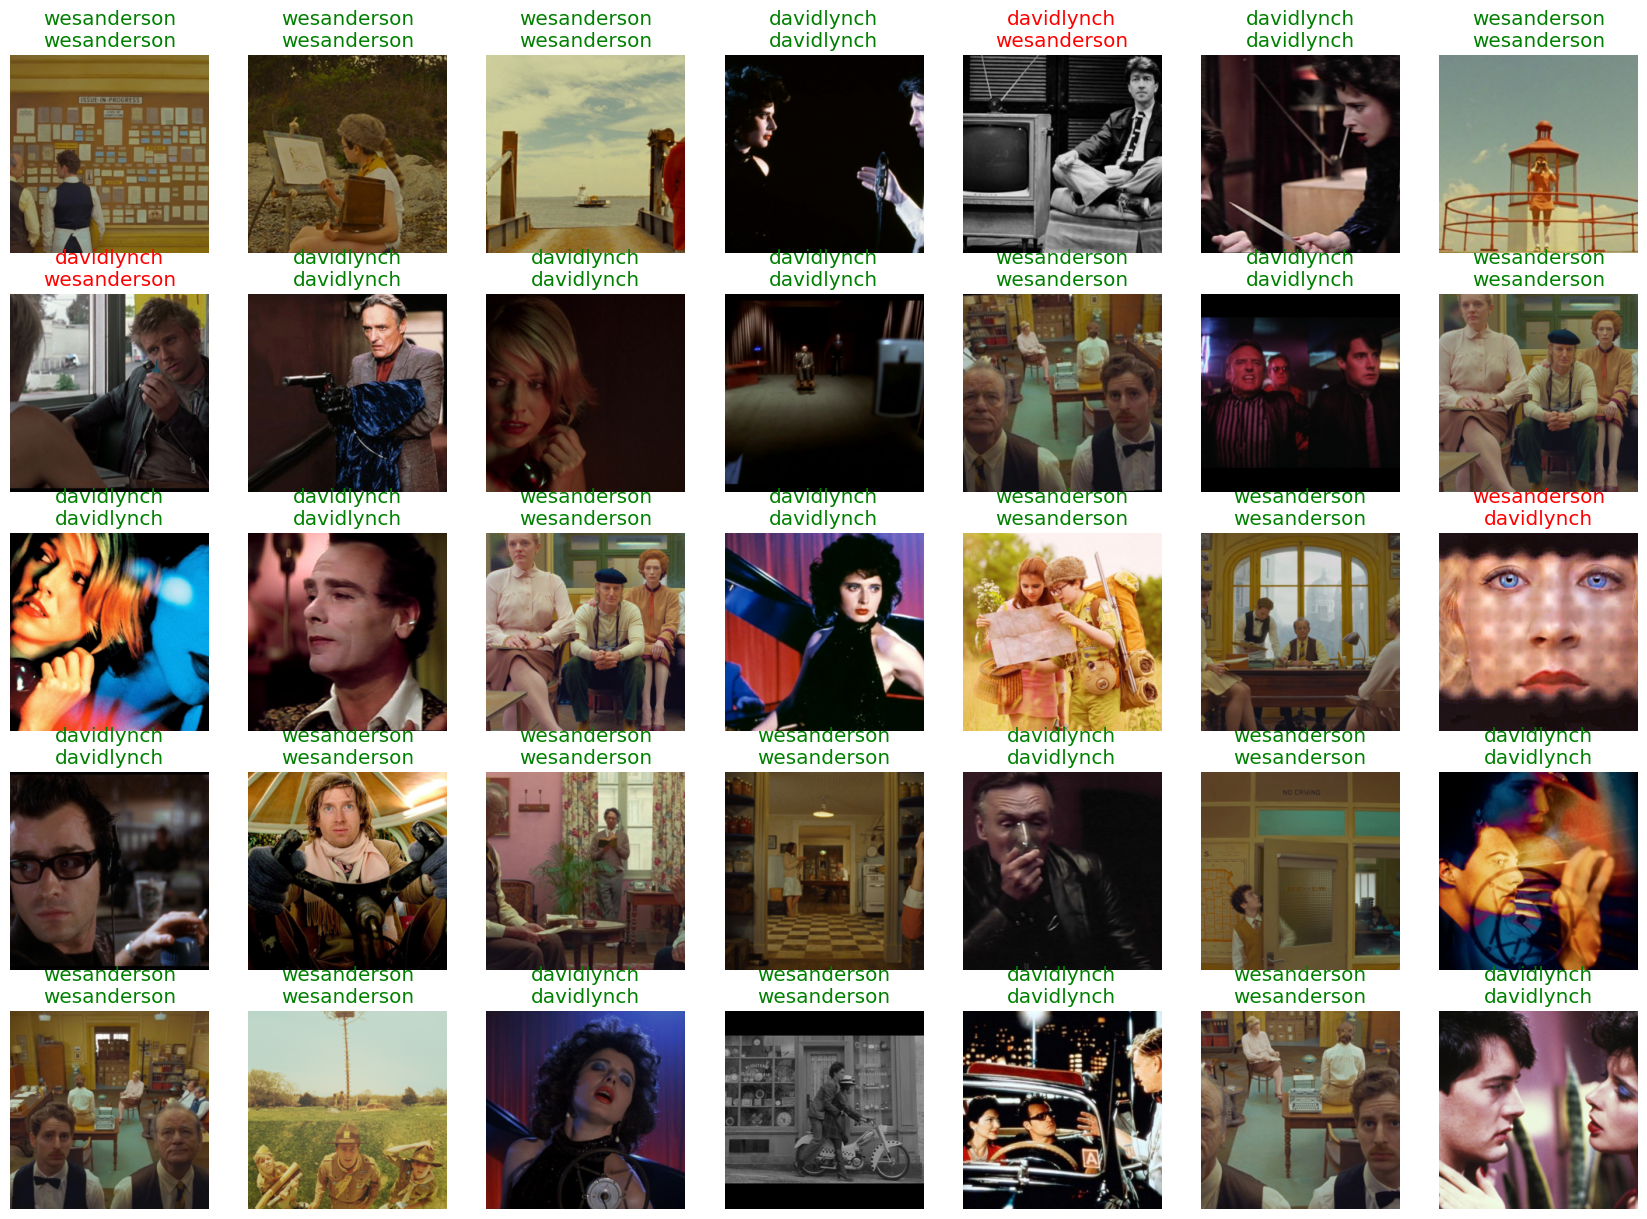

In [249]:
interp.show_results(list(range(0,104,3)))

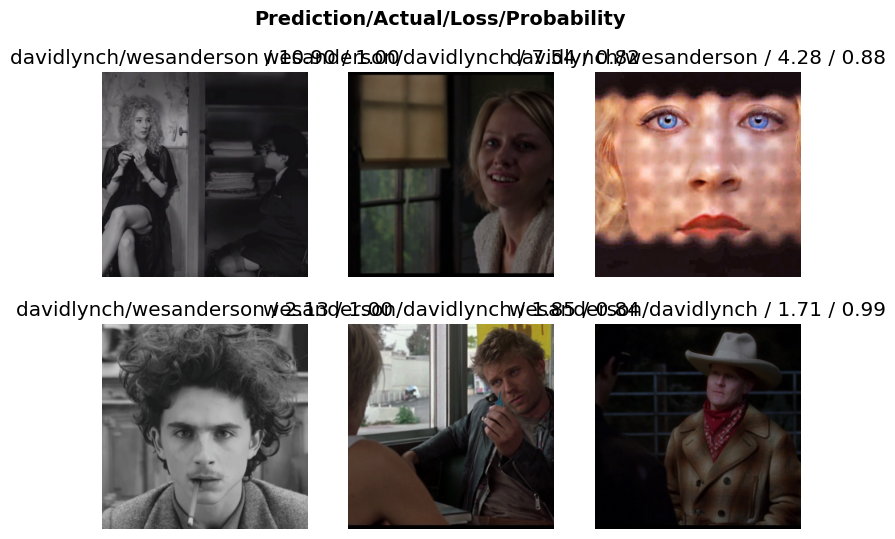

In [252]:
interp.plot_top_losses(6, nrows=2)